# Let's get the ball rolling!

This notebook was developed on top of one of the lessons by in [Python Data Science and Machine Learning Bootcamp on udemy.com](https://www.udemy.com/python-for-data-science-and-machine-learning-bootcamp)

At this stage we will do EDA and extract features that we might need.

We'll use a "semi-cleaned" version of the titanic data set, if you use the data set hosted directly on Kaggle, you may need to do some additional cleaning not shown in this lecture notebook.

##### Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Read the original Data in

Let's start by reading in the train and test csv files into a pandas dataframe.
If one uses kaggle-api to download datasets, they are available in a standardised location `~/.kaggle/competitions/`

In [2]:
train = pd.read_csv('~/.kaggle/competitions/titanic/train.csv')
test = pd.read_csv('~/.kaggle/competitions/titanic/test.csv')

In [3]:
#train = pd.read_csv('titanic_train.csv')
#test = pd.read_csv('titanic_test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


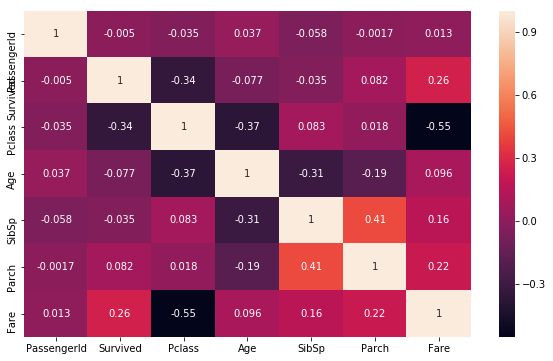

In [6]:
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(), annot=True)

# Exploratory Data Analysis (EDA)

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

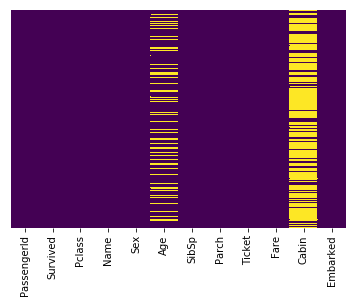

In [7]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

Let's continue on by visualizing some more of the data!

Text(0.5,1,'Survived counts')

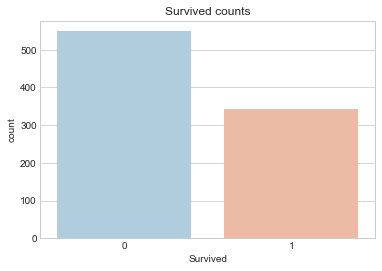

In [8]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', data=train, palette='RdBu_r')
plt.title('Survived counts')

Text(0.5,1,'Survived counts per gender')

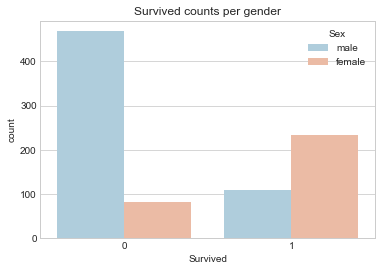

In [9]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', hue='Sex', data=train, palette='RdBu_r')
plt.title('Survived counts per gender')

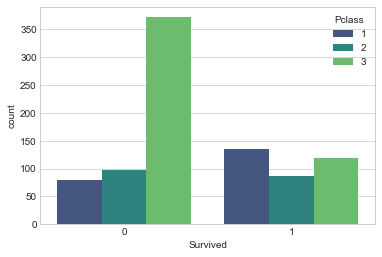

In [10]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', hue='Pclass', data=train, palette='viridis')

 There seems to be a clear correlation between the class and survival.

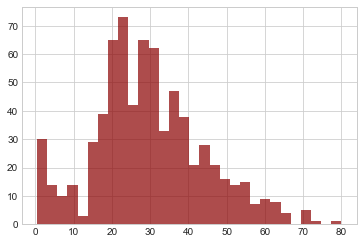

In [11]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

There seems to be less teenagers

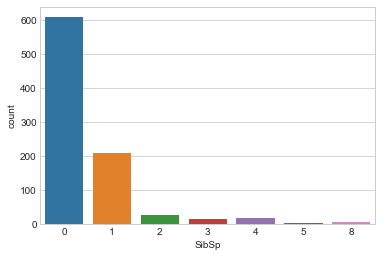

In [12]:
sns.countplot(x='SibSp',data=train)

Most were either alone or with a singlew family member

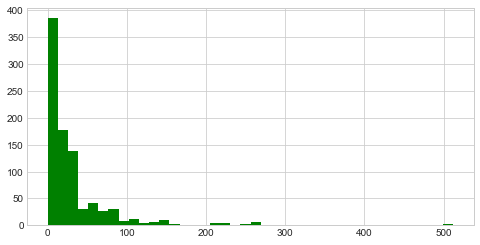

In [13]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

## Split the train dataset into training and validation samples

We do it early enough to avoid biases in sample cleaning and feature imputation

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=314)

In [16]:
train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_test,  y_test],  axis=1)

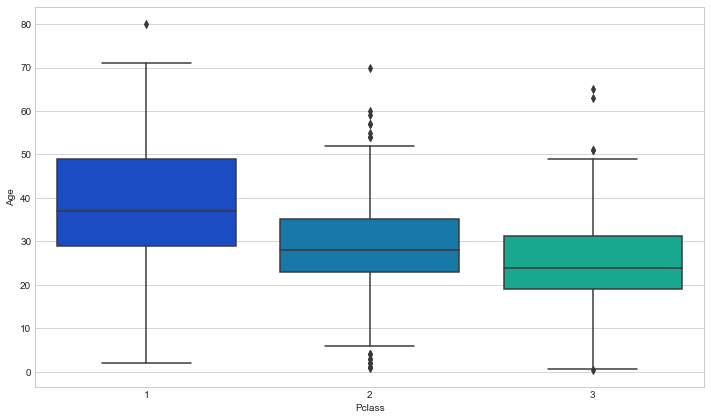

In [17]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use this observation to impute based on Pclass for Age.

In [18]:
age_PclassMean_encoding = train[['Pclass','Age']].groupby('Pclass').median()
age_mean = train['Age'].median()
fare_PclassMean_encoding = train[['Pclass','Fare']].groupby('Pclass').median()
fare_mean = train['Fare'].mean()

# a general function to  encode mean of a destination (=col0) var within each category of the reference
# this function should be universal for train/test samples
def encode_mean(cols, mean_encoding_df, mean_encoding_val, col0_name='Age'):
    destination = cols[0]
    reference = cols[1]
    
    if pd.isnull(destination):
        if reference in mean_encoding_df.index:
            return mean_encoding_df.loc[reference, col0_name]
        else:
            # If there is a class that was not encounted so far (e.g. np.nan), then impute the mean over the train column
            return mean_encoding_val
    else:
        return destination
    
def apply_impute_age(df):
    df['Age'] = df[['Age','Pclass']].apply(encode_mean, axis=1, args=(age_PclassMean_encoding, age_mean, 'Age'))

Now apply that function!

In [19]:
apply_impute_age(train)
apply_impute_age(valid)
apply_impute_age(test)

Now let's check train and validation heatmaps again!

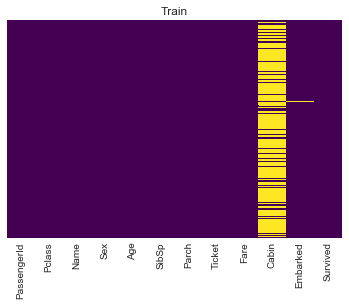

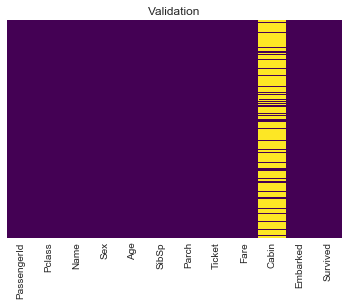

In [20]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Train')
plt.show()
sns.heatmap(valid.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Validation')
plt.show()

Great! Let's go ahead and deal with the Cabin column.

In [21]:
def deal_with_cabin(df):
    df['CabinKnown'] = df['Cabin'].isnull().astype(np.int8)
    df.drop('Cabin',axis=1,inplace=True)

In [22]:
deal_with_cabin(train)
deal_with_cabin(valid)
deal_with_cabin(test)

Let's drop remaining rows that are NaN.

In [23]:
train.dropna(inplace=True)
valid.dropna(inplace=True)

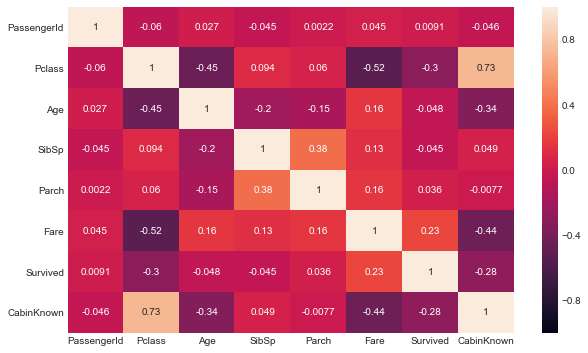

In [24]:
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(), annot=True, vmin=-1, vmax=1)

Existance of the Cabin info is highly correlated with the Pclass

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise some/many of our machine learning algorithm won't be able to directly take in those features as inputs.

In [25]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 621 entries, 524 to 520
Data columns (total 12 columns):
PassengerId    621 non-null int64
Pclass         621 non-null int64
Name           621 non-null object
Sex            621 non-null object
Age            621 non-null float64
SibSp          621 non-null int64
Parch          621 non-null int64
Ticket         621 non-null object
Fare           621 non-null float64
Embarked       621 non-null object
Survived       621 non-null int64
CabinKnown     621 non-null int8
dtypes: float64(2), int64(5), int8(1), object(4)
memory usage: 220.4 KB


There are 4 columns that contain strings: 'Name', 'Sex', 'Ticket', 'Embarked'. Let's do something to them...

### Age

Bin age values to sinplify training

In [26]:
#Not used so far
def ageBinning(age):
    bin_size = 5
    bin_id = int(age / bin_size)
    return 'AgeGroup_{}_to_{}'.format(bin_size*bin_id, bin_size*(bin_id+1))

Categorise children and senior to furter simplify training

In [27]:
def ageCategories(age):
    if(age < 16):
        return 'Child'
    elif(age > 60):
        return 'Senior'
    elif(age < 25):
        return 'Young'
    else:
        return 'Adult'

### Gender and Embark#

No custom functions needed

### Name

In [28]:
def getTitle(name):
    titles = ['Dr.', 'Mr.', 'Mrs.', 'Miss.', 'Master.']
    for title in titles:
        if title in name:
            return title
    #if none of the defined Titles
    return 'Other'

## Do the actual encoding of categories into dummies

In [29]:
def deal_with_categorical(df):
    # get dummies
    age_cats_dummies    = pd.get_dummies(df['Age'].apply(ageCategories), prefix='Age', drop_first=True)
    sex_cats_dummies    = pd.get_dummies(df['Sex'], prefix='Sex', drop_first=True)
    embark_cats_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked', drop_first=True)
    title_cats_dummies  = pd.get_dummies(df['Name'].apply(getTitle), prefix='Title', drop_first=True)
    
    # get dummies for Pclass as well, as it is a category, although stored as an int
    pclass_cats_dummies = pd.get_dummies(df['Pclass'], prefix='Pclass', drop_first=True)
    
    # merge dummies with the original DF and drop useless columns
    x = pd.concat([df, age_cats_dummies, sex_cats_dummies, embark_cats_dummies, title_cats_dummies, pclass_cats_dummies], axis=1)
    
    return x

In [30]:
train = deal_with_categorical(train)
valid = deal_with_categorical(valid)
test  = deal_with_categorical(test)

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 621 entries, 524 to 520
Data columns (total 25 columns):
PassengerId      621 non-null int64
Pclass           621 non-null int64
Name             621 non-null object
Sex              621 non-null object
Age              621 non-null float64
SibSp            621 non-null int64
Parch            621 non-null int64
Ticket           621 non-null object
Fare             621 non-null float64
Embarked         621 non-null object
Survived         621 non-null int64
CabinKnown       621 non-null int8
Age_Child        621 non-null uint8
Age_Senior       621 non-null uint8
Age_Young        621 non-null uint8
Sex_male         621 non-null uint8
Embarked_Q       621 non-null uint8
Embarked_S       621 non-null uint8
Title_Master.    621 non-null uint8
Title_Miss.      621 non-null uint8
Title_Mr.        621 non-null uint8
Title_Mrs.       621 non-null uint8
Title_Other      621 non-null uint8
Pclass_2         621 non-null uint8
Pclass_3         621 n

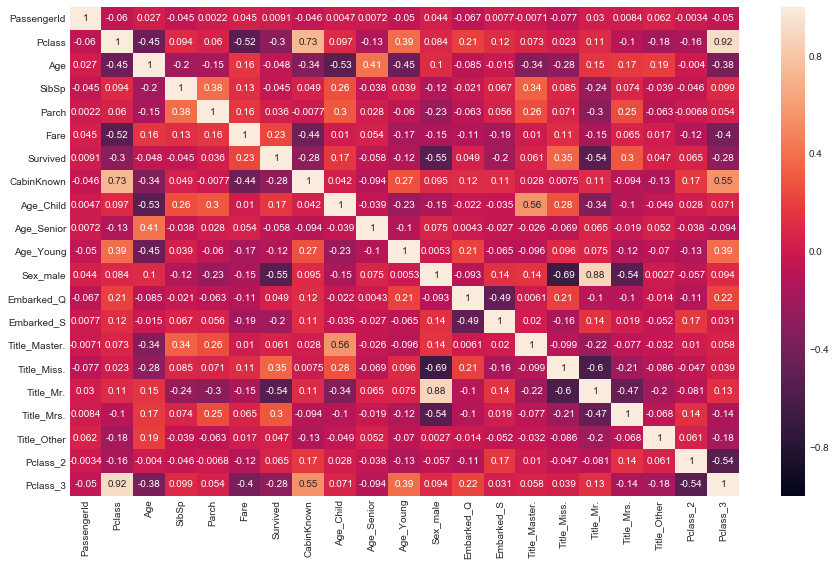

In [32]:
plt.figure(figsize=(15,9))
sns.heatmap(train.corr(), annot=True, vmin=-1, vmax=1)

### But before that let's check test sample for NaNs

Note, that we have already largely cleaned the test sample applying the same procedure as for train and valid samples.

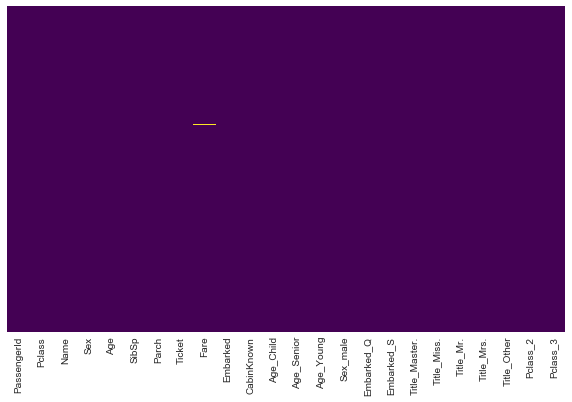

In [33]:
plt.figure(figsize=(10,6))
sns.heatmap(test.isnull(), cbar=False, yticklabels=False, cmap='viridis')

Good! The Age is comlete. But in the test sample we see a missing value for one entry in the `Fare` column. Let's impute it (it is natural to assume that Fare will be related to the Pclass)
### Encode Fare via Pclass as well

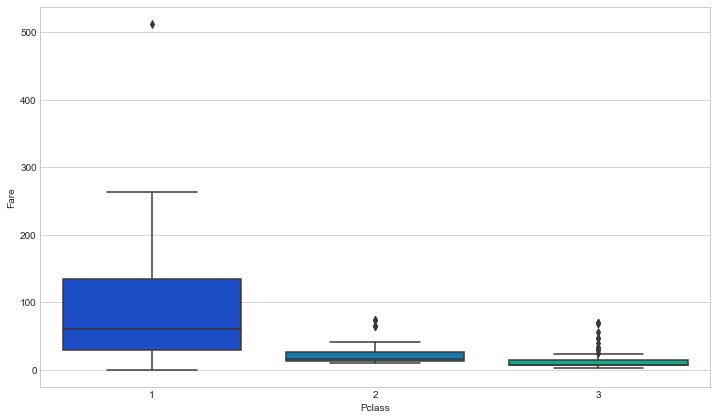

In [34]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Fare',data=test,palette='winter')

In [35]:
def apply_impute_fare(df):
    df['Fare'] = df[['Fare','Pclass']].apply(encode_mean, axis=1, args=(fare_PclassMean_encoding, fare_mean, 'Fare'))

In [36]:
apply_impute_fare(test)

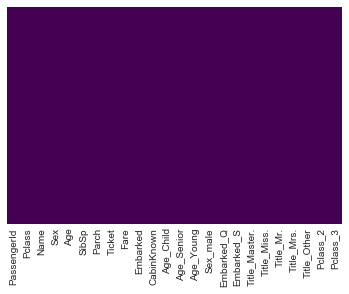

In [37]:
sns.heatmap(test.isnull(), cbar=False, yticklabels=False, cmap='viridis')

## Drop columns

In [38]:
def drop_columns(df):
    #drop categorical columns
    df.drop(['Sex','Embarked','Name','Ticket', 'Pclass'],axis=1,inplace=True)
    # PassengerId is just the index+1
    df.drop('PassengerId', axis=1, inplace=True)

In [39]:
drop_columns(train)
drop_columns(valid)
drop_columns(test)

Great! Our data is ready for our model!
## Let's store the  datasets

In [49]:
import os
out_dir = 'data'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

out_version = 'v0'
train.to_csv('{}/train_proc_{}.csv'.format(out_dir, out_version))
valid.to_csv('{}/valid_proc_{}.csv'.format(out_dir, out_version))
test .to_csv('{}/test_proc_{}.csv' .format(out_dir, out_version))

# Separate features and labels

In [41]:
# separate X and y values from the sample
def separate_X_and_y(df):
    return df.drop(columns='Survived'), df['Survived']

X_train, y_train = separate_X_and_y(train)
X_valid, y_valid = separate_X_and_y(valid)
X_test = test

# PCA and ICA

In [56]:
df_collection = {}
df_collection['y_train'] = y_train
df_collection['y_valid'] = y_valid

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

transforms = {'raw': None,
              'pca_trunk': PCA(svd_solver='full',  n_components='mle'),
              'pca_mini' : PCA(svd_solver='full',  n_components=10),
              'pca_full' : PCA(),
              'ica_full' : FastICA(random_state=314),
              'ica_mini' : FastICA(random_state=314, n_components=10)}


for t_name, t_obj in transforms.items():
    #special treatment to store the original untransformed features
    if not t_obj:
        df_collection['X_train_{}'.format('raw')] = X_train
        df_collection['X_valid_{}'.format('raw')] = X_valid
        df_collection['X_test_{}'.format('raw')] = X_test
        continue
    t_obj.fit(X_train)
    df_collection['X_train_{}'.format(t_name)] = t_obj.transform(X_train)
    df_collection['X_valid_{}'.format(t_name)] = t_obj.transform(X_valid)
    df_collection['X_test_{}'.format(t_name)] = t_obj.transform(X_test)


# Scalers

In [57]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [58]:
X_scaled = {}
scalers = {'StandardScaler': StandardScaler(), 
           'MinMaxScaler': MinMaxScaler()}

for sc_name,sc in scalers.items():
    for t_name in transforms.keys():
        sc.fit(df_collection['X_train_{}'.format(t_name)])
        X_scaled['X_train_{}_{}'.format(t_name, sc_name)] = sc.transform(df_collection['X_train_{}'.format(t_name)])
        X_scaled['X_valid_{}_{}'.format(t_name, sc_name)] = sc.transform(df_collection['X_valid_{}'.format(t_name)])
        X_scaled['X_test_{}_{}'.format(t_name, sc_name)] = sc.transform(df_collection['X_test_{}'.format(t_name)])
    
df_collection.update(X_scaled)

The list of available feature permutations:

In [59]:
[s[len('X_train_'):] for s in  df_collection.keys() if 'X_train' in s]

['raw',
 'pca_trunk',
 'pca_mini',
 'pca_full',
 'ica_full',
 'ica_mini',
 'raw_StandardScaler',
 'pca_trunk_StandardScaler',
 'pca_mini_StandardScaler',
 'pca_full_StandardScaler',
 'ica_full_StandardScaler',
 'ica_mini_StandardScaler',
 'raw_MinMaxScaler',
 'pca_trunk_MinMaxScaler',
 'pca_mini_MinMaxScaler',
 'pca_full_MinMaxScaler',
 'ica_full_MinMaxScaler',
 'ica_mini_MinMaxScaler']

## Store processed features in a pickle file as a dictionary

In [60]:
import pickle
pickle.dump(df_collection, open( "{}/Xy_collection_{}.pickle".format(out_dir, out_version), "wb" ))